### Implementation of QAOA and the alternating operator ansatz for the Travelling Salesperson Problem

In [12]:
# imports
%load_ext autoreload
%autoreload 2
from helper import create_tsp_graph,plot_tsp_graph,bitstring_to_path,cost
from classical import solve_tsp_classical
from alternating_operator import get_expectation,analyse_result
from scipy.optimize import minimize
from qiskit.tools.visualization import plot_histogram
from qiskit import transpile,Aer
from qaoa import get_expectation_qaoa,create_classical_qaoa_circ
import pickle
from numpy.random import rand
import matplotlib.pyplot as plt
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Alternating operator ansatz

In [2]:
# No. of repetitions of the mixer-phase separator scheme
reps = 3
ncities = 5

# number of shots taken in each iteration of the optimization
nshots = 1024
# set to True if intermediate counts should be saved for animation purposes (see anim.py)
extended_logging = True

In [3]:
G = create_tsp_graph(ncities)

if extended_logging:
    #Pickling
    with open(".\data\G", "wb") as f:   
        pickle.dump(G,f)

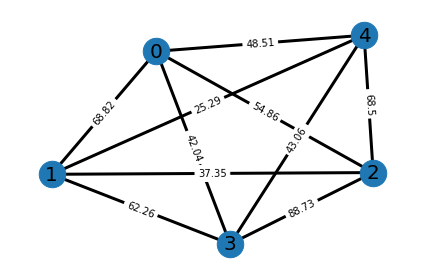

In [20]:
plot_tsp_graph(G)

In [8]:
# optimize circuit parameters to find the best path

expectation = get_expectation(G,reps,shots=nshots,log_intermediate_counts=extended_logging)

# initial circuit parameters
initial_params = [1. if i<reps*2 else np.random.rand()*2 for i in range(reps*4)]

# minimize expected cost
res = minimize(expectation,
               initial_params,
                      method='COBYLA',
                      options = {'tol' : 1e-6,'disp' : True})

Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.


Current expected cost: 278.04
Current expected cost: 278.04
Current expected cost: 278.04
Current expected cost: 278.04
Current expected cost: 278.04
Current expected cost: 278.04
Current expected cost: 278.04
Current expected cost: 272.08
Current expected cost: 269.75
Current expected cost: 269.06
Current expected cost: 269.06
Current expected cost: 271.08
Current expected cost: 272.67
Current expected cost: 273.89
Current expected cost: 270.4
Current expected cost: 269.06
Current expected cost: 269.07
Current expected cost: 269.06
Current expected cost: 269.34
Current expected cost: 269.06
Current expected cost: 270.66
Current expected cost: 270.9
Current expected cost: 272.74
Current expected cost: 269.06
Current expected cost: 270.55
Current expected cost: 277.78
Current expected cost: 280.08
Current expected cost: 280.85
Current expected cost: 280.0
Current expected cost: 280.31
Current expected cost: 268.91
Current expected cost: 278.99
Current expected cost: 277.48
Current expec

In [9]:
# result of optimization
res

     fun: 262.6146573575993
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 174
  status: 1
 success: True
       x: array([0.96413206, 0.96414041, 1.01442414, 1.0203178 , 1.00859289,
       1.01545111, 1.34193885, 2.88261632, 2.92365195, 1.25081575,
       1.36856215, 0.69740158])

Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.


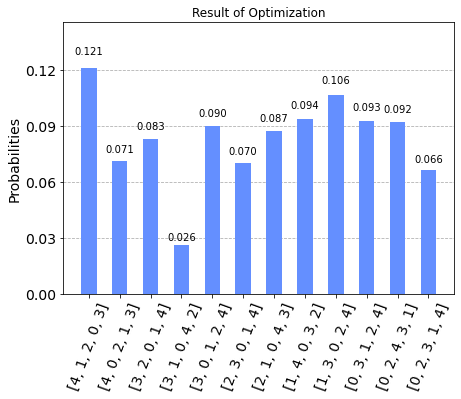

In [13]:
fig,counts = analyse_result(G,res.x,reps=reps,transform_labels_to_path=True,filter_unique_path=True,save_plot=extended_logging)
fig

In [14]:
# print all paths that are present in counts with their respective cost 
for key, val in counts.items():
    if val>1:
        path = bitstring_to_path(key)
        print(path,':', val , f"   cost = {round(cost(G,path),2)}")

[2, 1, 0, 4, 3] : 89    cost = 286.48
[3, 2, 0, 1, 4] : 85    cost = 280.77
[4, 1, 2, 0, 3] : 124    cost = 202.62
[1, 3, 0, 2, 4] : 109    cost = 252.96
[2, 3, 0, 1, 4] : 72    cost = 293.39
[0, 2, 4, 3, 1] : 94    cost = 297.51
[3, 0, 1, 2, 4] : 92    cost = 259.78
[0, 3, 1, 2, 4] : 95    cost = 258.66
[0, 2, 3, 1, 4] : 68    cost = 279.65
[1, 4, 0, 3, 2] : 96    cost = 241.93
[4, 0, 2, 1, 3] : 73    cost = 246.05
[3, 1, 0, 4, 2] : 27    cost = 336.82


In [15]:
# find optimal path with a classical algorithm 
solve_tsp_classical(G)

([0, 2, 1, 4, 3], 202.61580295979547)

### Classical QAOA implementation 

In [19]:
expectation_qaoa = get_expectation_qaoa(G,reps,shots=nshots,penalty=0.1,log_intermediate_counts=extended_logging)

inital_params_qaoa = [1 for _ in range(reps*2)]

res_qaoa = minimize(expectation_qaoa,
                    inital_params_qaoa,
                      method='COBYLA',
                      options = {'tol' : 1e-4,'disp' : True})

Current expected cost: 443.64
Current expected cost: 443.64
Current expected cost: 443.64
Current expected cost: 443.64
Current expected cost: 443.64
Current expected cost: 443.64
Current expected cost: 443.64
Current expected cost: 443.64
Current expected cost: 443.64
Current expected cost: 443.64
Current expected cost: 443.64
Current expected cost: 443.64
Current expected cost: 443.64
Current expected cost: 443.64
Current expected cost: 443.64
Current expected cost: 443.64
Current expected cost: 443.64
Current expected cost: 443.64
Current expected cost: 443.64
Current expected cost: 443.64
Current expected cost: 443.64
Current expected cost: 443.64
Current expected cost: 443.64
Current expected cost: 443.64
Current expected cost: 443.64
Current expected cost: 443.64
Current expected cost: 443.64
Current expected cost: 443.64
Current expected cost: 443.64
Current expected cost: 443.64



KeyboardInterrupt



In [17]:
res_qaoa

     fun: 443.63647945568266
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 37
  status: 1
 success: True
       x: array([1., 1., 1., 1., 1., 1.])

Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.


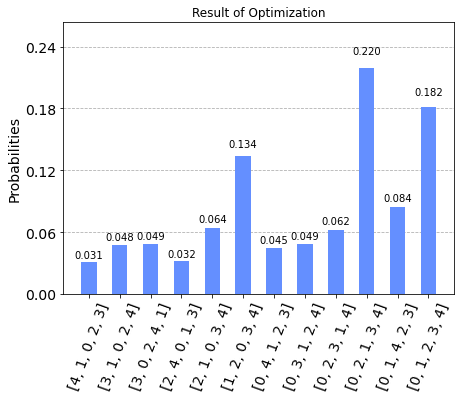

In [18]:
fig,counts = analyse_result(G,np.hstack([np.array([1. for _ in range(reps*2)]),res_qaoa.x]),reps=reps,transform_labels_to_path=True,filter_unique_path=True)
fig

## If 0,1,2,3,4 is "good" -> the algorithm almost always converges to that value 

### Compute ciruit sizes of the two algorithms

In [223]:
def compute_circuit_sizes(ncities_max=6,reps=1):
    sizes_alternating_operator = []
    sizes_qaoa = []
    simulator = Aer.get_backend('aer_simulator')
    x = []
    
    for ncities in range(2,ncities_max+1,1):
        G = create_tsp_graph(ncities)
        x.append(ncities)
        
        alt_op = create_qaoa_circ(G,reps=reps)
        alt_op = transpile(alt_op, simulator,optimization_level = 3)
        sizes_alternating_operator.append(alt_op.depth())
        
        qaoa = create_classical_qaoa_circ(G,reps=reps)
        qaoa = transpile(qaoa, simulator,optimization_level = 1)
        sizes_qaoa.append(qaoa.depth())
    
    
    return (x,sizes_alternating_operator,sizes_qaoa)
        

In [225]:
compute_circuit_sizes(5,2)

([2, 3, 4, 5], [136, 771, 1656, 2738], [12, 37, 85, 211])

### Plot expected cost over the iterations

In [124]:
# path where to save the figure, set to None if you do not want to save it 
save_path = "CompQAOA_ALT_op_qaoa_takes_first_sol.png"

In [125]:
# values copied from above optimization
cost_alt_op = [214.75, 214.75, 214.75, 214.75, 214.75, 185.56, 191.51, 185.56, 183.3, 190.9, 188.1, 183.3, 180.82, 180.82, 199.72, 180.82, 200.85, 220.16, 204.53, 196.46, 180.82, 191.52, 200.51, 180.63, 212.7, 187.86, 197.19, 180.63, 191.26, 180.63, 200.99, 180.63, 215.89, 189.92, 184.94, 180.63, 203.12, 207.74, 179.78, 184.02, 179.78, 205.59, 179.78, 189.34, 179.78, 189.34, 173.54, 191.08, 174.71, 207.36, 176.53, 180.51, 191.31, 177.24, 173.18, 174.82, 173.18, 173.55, 173.27, 173.98, 171.65, 174.91, 171.65, 174.17, 173.72, 173.72, 170.03, 170.75, 171.12, 170.75, 170.75, 171.02, 170.39, 170.3, 170.21, 171.56, 170.21, 171.21, 170.48, 170.21, 170.3, 170.21, 170.3, 170.3, 170.21, 170.3, 170.12, 170.12, 170.3, 170.12, 170.21, 169.94, 169.94, 170.12, 170.21, 170.03, 170.3, 170.03, 170.03, 170.12, 170.3, 170.12, 169.94, 170.12, 170.03, 169.94, 170.03, 169.94, 170.12, 170.03, 169.94, 170.03, 169.94, 169.94, 169.94, 169.94, 169.94]
cost_qaoa = [318.07, 318.25, 318.25, 318.07, 318.06, 313.6, 318.25, 318.25, 318.07, 313.6, 317.69, 281.86, 310.08, 275.59, 221.34, 279.96, 222.77, 221.15, 244.24, 235.31, 225.62, 221.15, 224.01, 223.15, 221.15, 221.34, 221.06, 221.06, 221.06, 221.06, 221.15, 221.06, 221.06, 221.06, 221.06, 221.06, 221.06, 221.06, 221.06, 221.06]

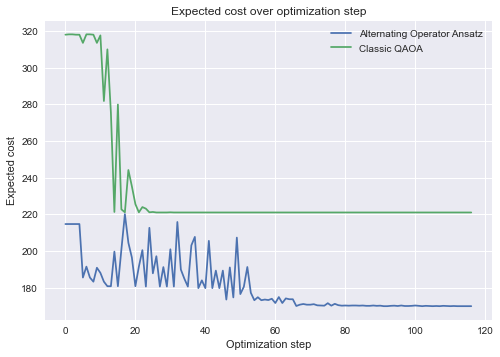

In [120]:
plt.style.use('seaborn')
plt.plot([i for i in range(len(cost_alt_op))],cost_alt_op,cost_qaoa+[cost_qaoa[-1] for _ in range(len(cost_alt_op)-len(cost_qaoa))])
plt.title("Expected cost over optimization step")
plt.xlabel("Optimization step")
plt.ylabel("Expected cost")
plt.legend(['Alternating Operator Ansatz','Classic QAOA'])

if save_path is not None:
    plt.savefig(save_path,dpi=1024)